In [1]:
import os
import sys
import json
import argparse
from time import time
from functools import partial

import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.preprocessing import normalize
from sklearn.random_projection import GaussianRandomProjection
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

from rsq.samplers import *
from rsq.samplers import _Sampler
from rsq.helpers import set_seeds

from rsq import SVCEnsemble, AgglomerativeEnsemble
from rsq.agglomerative_helpers import get_tree_distances, get_decision_paths

from joblib import Parallel, delayed

import torchvision

import pickle

def stratified_sample(y, p=0.67, replace=False):
    unique_y, counts = np.unique(y, return_counts=True)
    n_per_class = np.array([int(np.math.floor(p*c)) for c in counts])
    n_per_class = np.array([max([npc, 1]) for npc in n_per_class])
    
    inds = [np.random.choice(np.where(y == unique_y[i])[0], size=npc, replace=replace) for i, npc in enumerate(n_per_class)]
    
    return np.concatenate(inds)

def few_shot_sample(y, n_samples_per_class=1):
    unique_y = np.unique(y)    
    inds = [np.random.choice(np.where(y == c)[0], size=n_samples_per_class, replace=False) for c in unique_y]
    
    return np.concatenate(inds)

In [2]:
#- Data processing 1

class Dataset:
    def __init__(self, file='cifar_100_Bit_m-r101x1_embd.p', train=True, classes=[]):
        if train:
            self.data = pickle.load(open(file, 'rb'))[0][0]
            self.targets = np.concatenate(pickle.load(open(file, 'rb'))[0][1])
        else:
            self.data = pickle.load(open(file, 'rb'))[1][0]
            self.targets = np.concatenate(pickle.load(open(file, 'rb'))[1][1])
        
        self.classes = classes

In [3]:
#- Data processing 2
cif100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)

file='/home/hhelm/data/cifar_100_Bit_m-r101x1_embd.p'


trainset = Dataset(file, train=True, classes=cif100.classes)
X = trainset.data
y = trainset.targets

testset = Dataset(file, train=False, classes=cif100.classes)
X_test = testset.data
y_test = testset.targets

del trainset, testset, cif100

Files already downloaded and verified


In [4]:
def benchmark_agg_class(X, y, inds_sup, kwargs):
    y_ = -1 * np.ones(len(y))
    y_[inds_sup] = y[inds_sup]
    
    agg_class = AgglomerativeEnsemble(**kwargs)
    fit_time_ = time()
    agg_class.fit(X, y_)
    fit_time = time() - fit_time_
    
    inf_time_ = time()
    accuracy = (agg_class.predict(X_test) == y_test).mean()
    inf_time = time() - inf_time_
    
    print(accuracy, fit_time, inf_time)
    
    return accuracy, fit_time, inf_time

benchmark = lambda x: benchmark_agg_class(*x)

In [14]:
np.random.seed(1)
import copy

projection_dimension_list = [1, 4, 16, 64, 256, 1024]
kwargs = {'n_estimators':1, 'p_inbag':1, 
          'projector':'gaussian', 'projection_kwargs':{'n_components': 256}, 
          'affinity':'euclidean', 'linkage':'average', 
          'max_tree_distance':400, 'n_jobs':50}

n_cores=50
# n_mc=int(n_cores / len(prop_labeled))
n_mc=10

experiment_tuples = []
for i, projection_dimension in enumerate(projection_dimension_list):
    for _ in range(n_mc):
        temp_kwargs = copy.deepcopy(kwargs)
        temp_kwargs['projection_kwargs']['n_components'] = projection_dimension
        
        all_inds = stratified_sample(y, p=0.2, replace=False)
        inds_sup = few_shot_sample(y[all_inds])
        experiment_tuples.append((X[all_inds], y[all_inds], inds_sup, temp_kwargs))
    
start_time = time()
try:
    results_p_unlabeled = Parallel(n_jobs=n_cores)(delayed(benchmark)(tupl) for tupl in experiment_tuples)
    print("finished in %1.1f"%(time() - start_time))
except:
    print("error after %1.1f"%(time() - start_time))
    assert 0 == 1

finished in 49.8


In [7]:
kwargs

{'n_estimators': 1,
 'p_inbag': 1,
 'projector': 'gaussian',
 'projection_kwargs': {'n_components': 1024},
 'affinity': 'euclidean',
 'linkage': 'average',
 'max_tree_distance': 400,
 'n_jobs': 50}

In [16]:
accuracies = np.zeros((len(projection_dimension_list), n_mc))
fit_times = np.zeros((len(projection_dimension_list), n_mc))
inf_times = np.zeros((len(projection_dimension_list), n_mc))

for i, triple in enumerate(results_p_unlabeled):
    for j in range(n_mc):
        accuracies[int(np.math.floor(i/n_mc)), j] = triple[0]
        fit_times[int(np.math.floor(i/n_mc)), j] = triple[1]
        inf_times[int(np.math.floor(i/n_mc)), j] = triple[2]

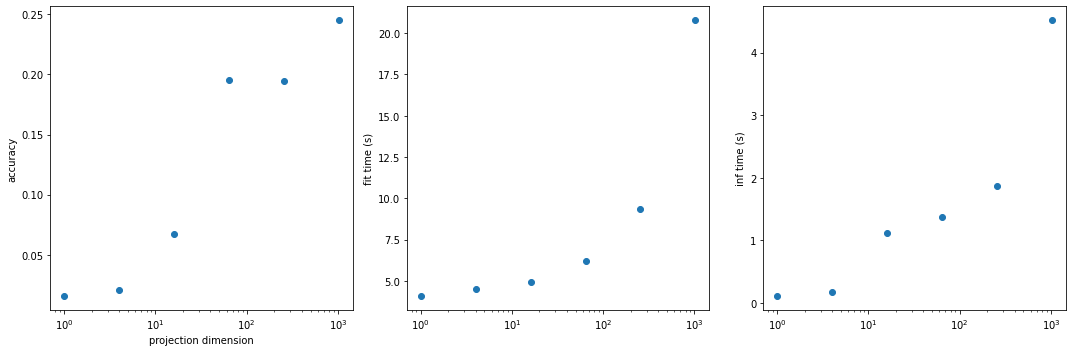

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,5))

for ax_ in ax:
    ax_.set_xscale('log')

ax[0].scatter(projection_dimension_list, np.mean(accuracies, axis=-1))
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('projection dimension')

# fig, ax = plt.subplots(1,3)
ax[1].scatter(projection_dimension_list, np.mean(fit_times, axis=-1))
ax[1].set_ylabel('fit time (s)')
# ax[1].set_xlabel('proportion o')

# fig, ax = plt.subplots(1,3)
ax[2].scatter(projection_dimension_list, np.mean(inf_times, axis=-1))
ax[2].set_ylabel('inf time (s)')
# ax[2].set_xlabel('proportion of')

plt.tight_layout()